In [6]:
from matplotlib import pyplot as plt

def show_img(tensor):
    plt.figure(figsize=(15, 15))
    plt.imshow(tensor.squeeze().permute(1,2,0).detach().numpy())
    plt.show()

# Data

In [7]:
# load adatasets
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
import tensorflow as tf
from torch.optim import lr_scheduler
import itertools
import random

class ImageFolderDataset(Dataset):
    def __init__(self, first_dir, second_dir, transform=None):
        self.first_dir = first_dir
        self.second_dir = second_dir
        
        self.transform = transform
        self.first_dir_paths = [os.path.join(first_dir, fname) for fname in os.listdir(first_dir) if fname.endswith(('png', 'jpg', 'jpeg'))]
        self.second_dir_paths = [os.path.join(second_dir, fname) for fname in os.listdir(second_dir) if fname.endswith(('png', 'jpg', 'jpeg'))]
        self.cache_first = dict()
        self.cache_second = dict()

    def __len__(self):
        return min(len(self.first_dir_paths), len(self.second_dir_paths))

    def __getitem__(self, idx):        
        first_img_path = self.first_dir_paths[idx]
        second_img_path = self.second_dir_paths[idx]
        
        if first_img_path in self.cache_first:
            first_image = self.cache_first[first_img_path]
        else:
            first_image = Image.open(first_img_path).convert("RGB")
            self.cache_first[first_img_path] = first_image
            
        if second_img_path in self.cache_second:
            second_image = self.cache_second[second_img_path]
        else:
            second_image = Image.open(second_img_path).convert("RGB")
            self.cache_second[second_img_path] = second_image
        
        if self.transform:
            first_image = self.transform(first_image)
            second_image = self.transform(second_image)
        return first_image, second_image
    
class SingleFolderDataset(Dataset):
    def __init__(self, first_dir, transform=None):
        self.first_dir = first_dir
        
        self.transform = transform
        self.first_dir_paths = [os.path.join(first_dir, fname) for fname in os.listdir(first_dir) if fname.endswith(('png', 'jpg', 'jpeg'))]
        self.cache_first = dict()

    def __len__(self):
        return len(self.first_dir_paths)

    def __getitem__(self, idx):        
        first_img_path = self.first_dir_paths[idx]
        
        if first_img_path in self.cache_first:
            first_image = self.cache_first[first_img_path]
        else:
            first_image = Image.open(first_img_path).convert("RGB")
            self.cache_first[first_img_path] = first_image
        
        if self.transform:
            first_image = self.transform(first_image)
        return first_image
    
class ImageBuffer():
    def __init__(self):
        self.buffer = []
        self.max_size = 50
    
    def push_and_pop(self, datas):
        return_imgs = []
        for element in datas.data:
            element = torch.unsqueeze(element, 0)
            if len(self.buffer) < self.max_size:
                self.buffer.append(element)
                return_imgs.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    return_imgs.append(self.buffer[i].clone())
                    self.buffer[i] = element
                else:
                    return_imgs.append(element)
                    
        return torch.cat(return_imgs, 0)


In [8]:
dataset = ImageFolderDataset('/kaggle/input/gan-getting-started/photo_jpg', '/kaggle/input/gan-getting-started/monet_jpg', transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the image to 256x256
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
]))

dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, pin_memory=True)

# Model

In [9]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv_1 = nn.Conv2d(
            in_channels = in_c,
            out_channels = out_c,
            kernel_size = 3,
            padding=1
        )
        self.relu_1 = nn.ReLU()
        self.conv_2 = nn.Conv2d(
            in_channels = out_c,
            out_channels = out_c,
            kernel_size = 3,
            padding=1
        )
        self.relu_2 = nn.ReLU()
        self.conv_3 = nn.Conv2d(
            in_channels = out_c,
            out_channels = out_c,
            kernel_size = 3,
            padding=1
        )
        self.relu_3 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu_1(x)
        x = self.conv_2(x)
        x = self.relu_2(x)
        x = self.conv_3(x)
        x = self.relu_3(x)
        return x
    
class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2,2))
    
    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, p
    
class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c*2, out_c)
        
    def forward(self, x, residual):
        x = self.up(x)        
        x = torch.cat([x, residual], axis=1)
        x = self.conv(x)
        return x

In [10]:
class UNET_Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_1 = EncoderBlock(3, 64) # (64, 128, 128)
        self.enc_2 = EncoderBlock(64, 128) # (128, 64, 64)
        self.enc_3 = EncoderBlock(128, 256) # (256, 32, 32)
        self.enc_4 = EncoderBlock(256, 512) # (512, 16, 16)
        
        self.bridge = conv_block(512, 1024) # (1024, 16, 16)
        
        self.dec_1 = DecoderBlock(1024, 512) # (512, 32, 32)
        self.dec_2 = DecoderBlock(512, 256) # (256, 64, 64)
        self.dec_3 = DecoderBlock(256, 128) # (128, 128, 128)
        self.dec_4 = DecoderBlock(128, 64) # (64, 256, 256)
        
        self.final = nn.Conv2d(64, 3, kernel_size=1, padding=0)
        self.activation = nn.Tanh()
        
    def forward(self, x):
        x_enc_1, x = self.enc_1(x)        
        x_enc_2, x = self.enc_2(x)        
        x_enc_3, x = self.enc_3(x)        
        x_enc_4, x = self.enc_4(x)
        
        bridge = self.bridge(x)
        
        result = self.dec_1(bridge, x_enc_4)  
        result = self.dec_2(result, x_enc_3)
        result = self.dec_3(result, x_enc_2)
        result = self.dec_4(result, x_enc_1)
        
        result = self.final(result)
        result = self.activation(result)
        return result
        

In [11]:
class DownSampleDis(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, isNorm=True):
        super().__init__()
        self._isNorm = isNorm
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2)
        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.LeakyReLU(negative_slope=0.2)
        
    def forward(self, x):
        out = self.conv(x)
        if self._isNorm:
            out = self.norm(out)
        out = self.relu(out)
        return out
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = []
        self.network.append(DownSampleDis(in_channels=3, out_channels=64, kernel_size=4, stride=2, isNorm=False))
        self.network.append(DownSampleDis(in_channels=64, out_channels=128, kernel_size=4, stride=2))
        self.network.append(DownSampleDis(in_channels=128, out_channels=256, kernel_size=4, stride=2))
        self.network.append(DownSampleDis(in_channels=256, out_channels=512, kernel_size=4, stride=2))
        self.network.append(nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1))
        self.avg_pool = nn.AvgPool2d((14,14))
        self.model = nn.Sequential(*self.network)

    def forward(self, x):
        x = self.model(x)
        x = nn.Dropout(0.5)(x)
        return self.avg_pool(x)

In [36]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)

# Training

In [12]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
L_CYCLE = 10
L_ID = 5
EPOCHS = 20
DECAY_EPOCHS = 20
LR = 2e-4
# Model
USE_IDENTITY = True

In [40]:
a_b_generator = UNET_Generator().to(DEVICE)
b_a_generator = UNET_Generator().to(DEVICE)

a_discriminator = Discriminator().to(DEVICE)
b_discriminator = Discriminator().to(DEVICE)

a_b_generator.apply(weights_init)
b_a_generator.apply(weights_init)
a_discriminator.apply(weights_init)
b_discriminator.apply(weights_init)

Discriminator(
  (avg_pool): AvgPool2d(kernel_size=(14, 14), stride=(14, 14), padding=0)
  (model): Sequential(
    (0): DownSampleDis(
      (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
      (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): LeakyReLU(negative_slope=0.2)
    )
    (1): DownSampleDis(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
      (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): LeakyReLU(negative_slope=0.2)
    )
    (2): DownSampleDis(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
      (norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): LeakyReLU(negative_slope=0.2)
    )
    (3): DownSampleDis(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
      (norm): Insta

In [41]:
# loss function
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizer & LR scheduler
optimizer_g = torch.optim.Adam(itertools.chain(a_b_generator.parameters(), b_a_generator.parameters()), lr=LR, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(itertools.chain(a_discriminator.parameters(), b_discriminator.parameters()), lr=LR, betas=(0.5, 0.999))

LambdaLR = lambda epoch: 1 - max(0, epoch - DECAY_EPOCHS + 1) / (EPOCHS - DECAY_EPOCHS + 1)
scheduler_G = lr_scheduler.LambdaLR(optimizer_g, lr_lambda=LambdaLR)
scheduler_D = lr_scheduler.LambdaLR(optimizer_d, lr_lambda=LambdaLR)

In [ ]:
from collections import defaultdict
from tqdm.auto import tqdm
logger = list()

for epoch in range(1, EPOCHS+1):
    loss_batch = defaultdict(float)
    x_fake_a_buffer = ImageBuffer()
    x_fake_b_buffer = ImageBuffer()
    
    total_g_loss = 0.0
    total_d_loss = 0.0
    
    for i, data in enumerate(tqdm(dataloader)):
        # Data
        x_a = data[0].to(DEVICE) #photo
        x_b = data[1].to(DEVICE) #monet

        # Generators
        a_b_generator.zero_grad()
        b_a_generator.zero_grad()

        # Generate
        x_fake_a = b_a_generator(x_b)
        x_fake_b = a_b_generator(x_a)

        # Adversarial
        x_adv_a = a_discriminator(x_fake_a)
        x_adv_b = b_discriminator(x_fake_b)

        # Cycle
        x_cycle_a = b_a_generator(x_fake_b)
        x_cycle_b = a_b_generator(x_fake_a)

        # Adversarial loss
        g_loss_adv_a = criterion_GAN(x_adv_a, torch.ones_like(x_adv_a))
        g_loss_adv_b = criterion_GAN(x_adv_b, torch.ones_like(x_adv_b))

        # Cycle loss
        g_loss_cycle_a = criterion_cycle(x_cycle_a, x_a) * L_CYCLE 
        g_loss_cycle_b = criterion_cycle(x_cycle_b, x_b) * L_CYCLE

        # Identity loss
        g_loss_identity_a = criterion_identity(x_cycle_a, x_a) * L_ID if USE_IDENTITY else 0
        g_loss_identity_b = criterion_identity(x_cycle_b, x_b) * L_ID if USE_IDENTITY else 0

        g_loss_a = g_loss_adv_a + g_loss_cycle_a + g_loss_identity_a
        g_loss_b = g_loss_adv_a + g_loss_cycle_b + g_loss_identity_b
        g_loss = (g_loss_a + g_loss_b) / 2 
              
        g_loss.backward()
        total_g_loss += g_loss.item()

        optimizer_g.step()

        # Discriminators
        a_discriminator.zero_grad()
        b_discriminator.zero_grad()

        # photo
        x_fake_a = x_fake_a_buffer.push_and_pop(x_fake_a)
        d_real_a = a_discriminator(x_a)
        d_fake_a = a_discriminator(x_fake_a.detach())
        
        # monet
        x_fake_b = x_fake_b_buffer.push_and_pop(x_fake_b)
        d_real_b = b_discriminator(x_b)
        d_fake_b = b_discriminator(x_fake_b.detach())

        # Discriminator Loss
        d_loss_a = criterion_GAN(d_real_a, torch.ones_like(d_real_a)) + criterion_GAN(d_fake_a, torch.zeros_like(d_fake_a))
        d_loss_b = criterion_GAN(d_real_b, torch.ones_like(d_real_b)) + criterion_GAN(d_fake_b, torch.zeros_like(d_fake_b))

        d_loss = (d_loss_a + d_loss_b) / 2

        d_loss.backward()
        total_d_loss += d_loss.item()
        optimizer_d.step()
    
    avg_g_loss = total_g_loss / len(dataloader)
    avg_d_loss = total_d_loss / len(dataloader)
    
    logger.append({
        'g_loss': avg_g_loss,
        'd_loss': avg_d_loss
    })

    scheduler_G.step()
    scheduler_D.step()
    
    print(f"Epoch: {epoch} | Generator Loss: {avg_g_loss} | Discriminator Loss: {avg_d_loss}")

  0%|          | 0/300 [00:00<?, ?it/s]

In [79]:
# Test
torch.save(a_b_generator, './model.ckpt')

In [14]:
# Model
a_b_generator = torch.load('./model.ckpt')

In [15]:
single_dataset = SingleFolderDataset('/kaggle/input/gan-getting-started/photo_jpg', transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the image to 256x256
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
]))

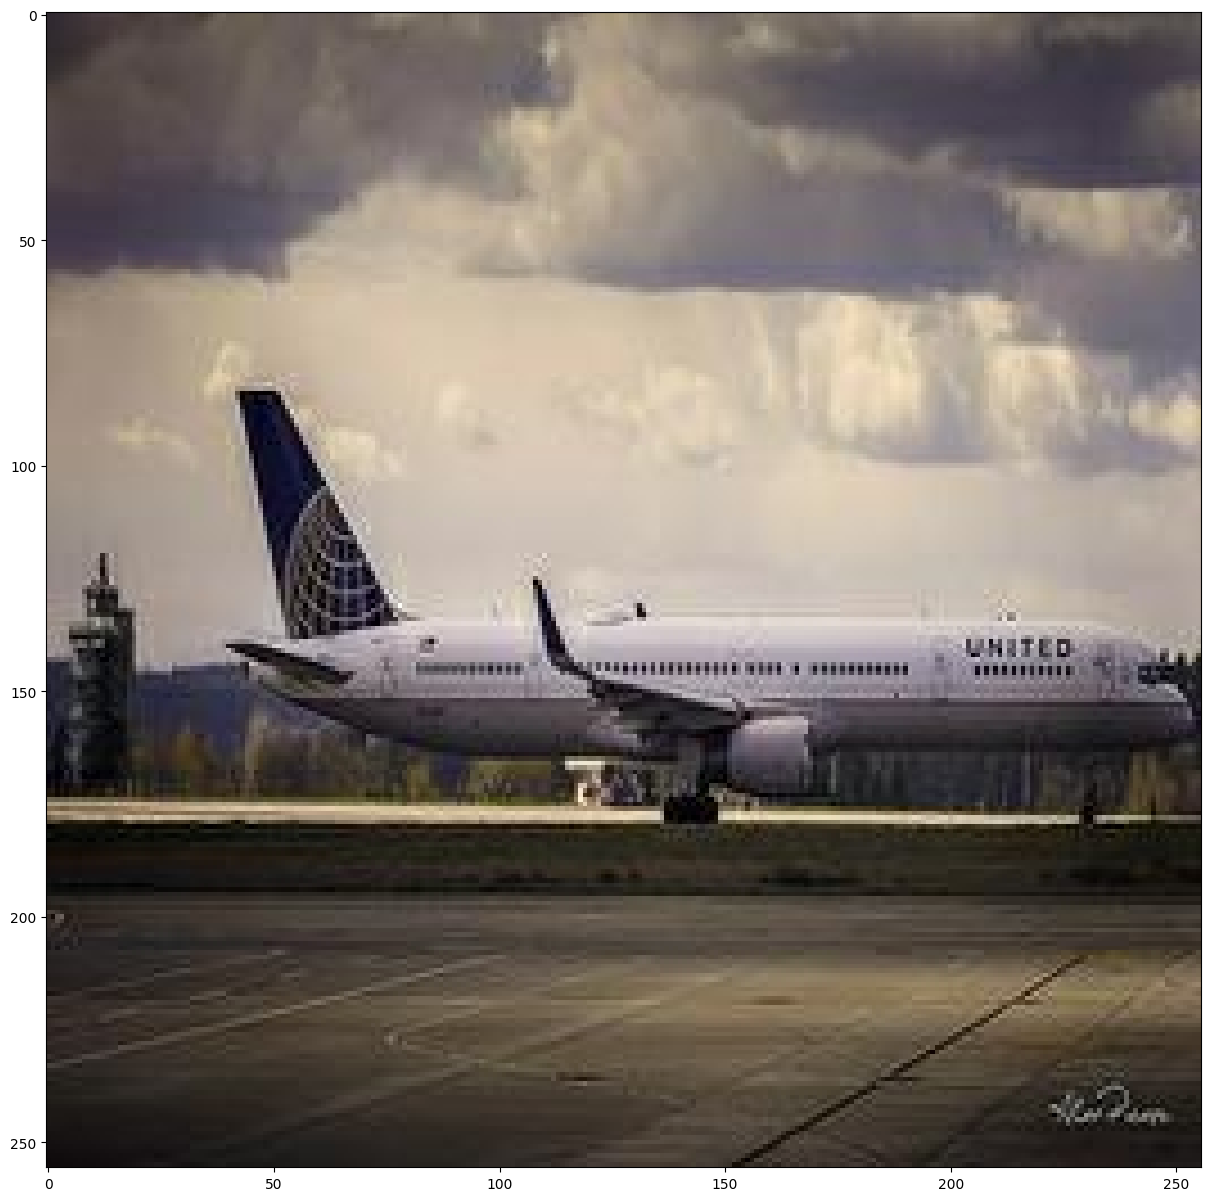

In [16]:
show_img((single_dataset[1000] + 1)/2)

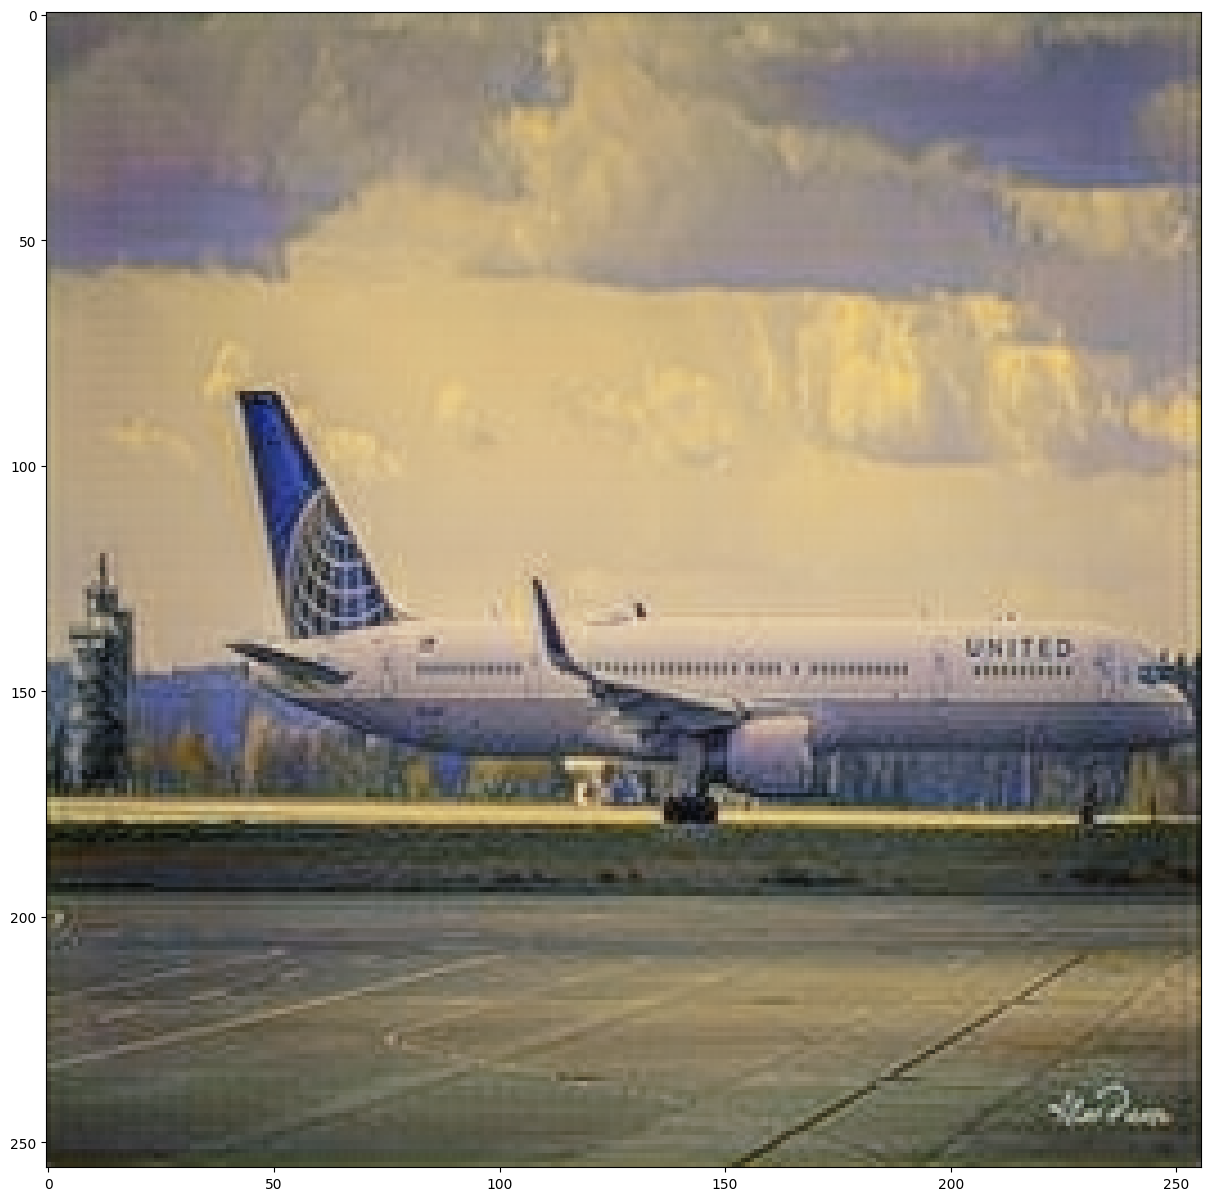

In [17]:
show_img((a_b_generator(single_dataset[1000].unsqueeze(0).cuda()).squeeze(0).cpu().detach() + 1)/2)

In [18]:
from tqdm import tqdm

images = []
test_dataloader = DataLoader(single_dataset)
a_b_generator = a_b_generator.eval()

with torch.no_grad():
    for img in tqdm(test_dataloader):
        result = a_b_generator(img.cuda())
        result = (result.cpu().detach().squeeze().numpy() + 1)/2
        images.append(result)

100%|██████████| 7038/7038 [04:08<00:00, 28.28it/s]


In [35]:
import numpy as np
from PIL import Image
import zipfile
import io

# Create a zip file in memory
zip_filename = "images.zip"
zip_buffer = io.BytesIO()

with zipfile.ZipFile(zip_buffer, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for i, tensor in tqdm(enumerate(images)):
        # Convert the tensor to a PIL image
        tensor = (tensor * 255).astype(np.uint8)
        image = Image.fromarray(np.transpose(tensor, (1, 2, 0)))
        
        # Save the image to a bytes buffer
        img_buffer = io.BytesIO()
        image.save(img_buffer, format='JPEG')
        img_buffer.seek(0)
        
        # Write the image buffer to the zip file
        zipf.writestr(f"image_{i}.jpg", img_buffer.read())

# Save the zip buffer to a file
with open(zip_filename, 'wb') as f:
    f.write(zip_buffer.getvalue())


7038it [00:15, 455.61it/s]


NameError: name 'num_tensors' is not defined